In [20]:
import torch
from torch import nn
from torch.nn import functional as F
import collections
import random
import time
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
from grid_method import *
from model import GHH

In [22]:
def get_region_1d(grad):
    grad_n = grad.numpy()
    grad_n = grad_n.reshape(-1)
    sp = grad_n.shape
    grad_n = grad_n.astype(str)
    _, dist = np.unique(grad_n, return_inverse = True)
    dist = dist.reshape(sp)
    return dist

In [23]:
def view_1d(d, output, region):
    d_n = d.detach().numpy().reshape(-1)
    output_n = output.detach().numpy().reshape(-1)
    n_region = len(set(region))
    regions = list(set(region))
    # choose colors
    cmp = plt.get_cmap("viridis")
    colors = cmp(np.linspace(0,1,n_region))
                 
    fig = plt.figure(figsize=(14, 8))
    
    plt.plot(d_n,output_n)
    for i, (r, color) in enumerate(zip(regions, colors), 1):
        ids = np.arange(len(d_n))
        ids_c = ids[region == r]
        d_n_c = d_n[ids_c]
        output_n_c = output_n[ids_c]
        plt.scatter(d_n_c, output_n_c, s=1)
        plt.axvspan(d_n_c[0], d_n_c[-1], facecolor=color, alpha=0.5)         
    plt.xlabel("x")
    plt.ylabel("output of GHH")
    plt.title("1D visualization",fontsize=25)
    plt.show()

In [86]:
d = torch.linspace(-20, 20, 2001)
d = d.reshape(-1,1)
d.requires_grad_(True)

tensor([[-20.0000],
        [-19.9800],
        [-19.9600],
        ...,
        [ 19.9600],
        [ 19.9800],
        [ 20.0000]], requires_grad=True)

In [87]:
ghh = GHH(d,1,3)
output = ghh(d)

In [88]:
output.backward(torch.ones_like(output))

grad = d.grad
reg = get_region_1d(grad)

In [89]:
set(reg.flatten())

{0, 1, 2, 3}

In [62]:
set(grad.flatten())

{tensor(-2.2560),
 tensor(-2.2560),
 tensor(-2.2560),
 tensor(-2.2560),
 tensor(-2.2560),
 tensor(-3.2436),
 tensor(-3.2436),
 tensor(-3.2611),
 tensor(-3.2611),
 tensor(-3.2611),
 tensor(-3.2611),
 tensor(-3.2611),
 tensor(-3.2611),
 tensor(-4.0229),
 tensor(-2.8615),
 tensor(-2.2560),
 tensor(-2.2560),
 tensor(-2.2560),
 tensor(-2.2560),
 tensor(-2.2560),
 tensor(-2.2560),
 tensor(-2.2560),
 tensor(-2.2560),
 tensor(-2.2560),
 tensor(-3.2436),
 tensor(-3.2436),
 tensor(-3.2611),
 tensor(-3.2611),
 tensor(-3.2611),
 tensor(-3.2611),
 tensor(-3.2611),
 tensor(-4.0229),
 tensor(-2.2560),
 tensor(-2.8615),
 tensor(-2.2560),
 tensor(-2.2560),
 tensor(-2.2560),
 tensor(-2.2560),
 tensor(-2.2560),
 tensor(-2.2560),
 tensor(-2.2560),
 tensor(-3.2436),
 tensor(-3.2436),
 tensor(-3.2611),
 tensor(-3.2611),
 tensor(-2.2560),
 tensor(-3.2611),
 tensor(-3.2611),
 tensor(-3.2611),
 tensor(-3.2611),
 tensor(-2.2560),
 tensor(-2.2560),
 tensor(-2.2560),
 tensor(-2.2560),
 tensor(-2.2560),
 tensor(-2

## test if the 1d case is right for K=3

In [98]:
def test_1d(n_iter):
    stats = np.empty((n_iter,1))
    for i in range(n_iter):
        d = torch.linspace(-20, 20, 2001)
        d = d.reshape(-1,1)
        d.requires_grad_(True)
        
        ghh = GHH(d,1,3)
        output = ghh(d)
        output.backward(torch.ones_like(output))

        grad = d.grad
        reg = get_region_1d(grad)
        n = len(set(reg.flatten()))
        stats[i,0] = n
        
    #save the data
    np.save('sanity_test.npy', stats)
    return stats

In [99]:
stats = test_1d(1000)

In [100]:
stats_equal4 = stats.copy()
stats_equal4[stats==4] = 1
stats_equal4[stats!=4] = 0
total = stats_equal4.sum()
ratio = total/1000
print(ratio)

0.892


In [106]:
stats_f = stats.flatten()

(1000,)

### the 1st architecture

In [107]:
def arch_1(d, k, l):
    ghh1 = GHH(d,1,k)
    res = ghh1(d)
    
    for i in range(l-1):
        ghh = GHH(d,1,k)
        res = res.clone()
        res = ghh(res)
        
    output = res.clone()
    return output

# reason of 'saturation'

### 1) check if the stepsize is not small enough

In [126]:
def nb_region_arch1(ls, n_iter, nb, save_name1, save_name2):
    avg_nbs = []
    stds = []
    for l in ls:
        stats = torch.empty(n_iter, 1)
        for i in range(n_iter):
            d = torch.linspace(-20, 20, nb)
            d = d.reshape(-1, 1)
            d.requires_grad_(True)
            output = arch_1(d, 3, l)
            output.backward(torch.ones_like(output))
            grad = d.grad.numpy().reshape(-1)
            
            stats[i,0] = len(set(grad))
        avg_nb = stats.mean(axis = 0)[0].item()
        std = stats.std(axis = 0)[0].item()
        avg_nbs.append(avg_nb)
        stds.append(std)
        print(f'{l}, finished.')
    # save the result
    avg_nbs_tosave = np.array(avg_nbs)
    stds_tosave = np.array(stds)
    np.save(save_name1, avg_nbs_tosave)
    np.save(save_name2, stds_tosave)
    return avg_nbs, stds

In [228]:
# def. of the layers number
ls = np.arange(0,101,10)
ls[0] = 1
ls

array([  1,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100])

In [157]:
ls[10]

100

In [131]:
# stepsize = 0.5
nbs_80, stds_80 = nb_region_arch1(ls, 1000, 81, 'data/arch1_nbs_80.npy', 'data/arch1_stds_80.npy')

1, finished.
10, finished.
20, finished.
30, finished.
40, finished.
50, finished.
60, finished.
70, finished.
80, finished.
90, finished.
100, finished.


In [128]:
# stepsize = 0.4
nbs_100, stds_100 = nb_region_arch1(ls, 1000, 101, 'data/arch1_nbs_100.npy', 'data/arch1_stds_100.npy')

1, finished.
10, finished.
20, finished.
30, finished.
40, finished.
50, finished.
60, finished.
70, finished.
80, finished.
90, finished.
100, finished.


In [132]:
# stepsize = 0.2
nbs_200, stds_200 = nb_region_arch1(ls, 1000, 201, 'data/arch1_nbs_200.npy', 'data/arch1_stds_200.npy')

1, finished.
10, finished.
20, finished.
30, finished.
40, finished.
50, finished.
60, finished.
70, finished.
80, finished.
90, finished.
100, finished.


In [133]:
# stepsize = 0.1
nbs_400, stds_400 = nb_region_arch1(ls, 1000, 401, 'data/arch1_nbs_400.npy', 'data/arch1_stds_400.npy')

1, finished.
10, finished.
20, finished.
30, finished.
40, finished.
50, finished.
60, finished.
70, finished.
80, finished.
90, finished.
100, finished.


In [134]:
# stepsize = 0.05
nbs_800, stds_800 = nb_region_arch1(ls, 1000, 801, 'data/arch1_nbs_800.npy', 'data/arch1_stds_800.npy')

1, finished.
10, finished.
20, finished.
30, finished.
40, finished.
50, finished.
60, finished.
70, finished.
80, finished.
90, finished.
100, finished.


In [135]:
# stepsize = 0.04
nbs_1000, stds_1000 = nb_region_arch1(ls, 1000, 1001, 'data/arch1_nbs_1000.npy', 'data/arch1_stds_1000.npy')

1, finished.
10, finished.
20, finished.
30, finished.
40, finished.
50, finished.
60, finished.
70, finished.
80, finished.
90, finished.
100, finished.


In [136]:
# stepsize = 0.02
nbs_2000, stds_2000 = nb_region_arch1(ls, 1000, 2001, 'data/arch1_nbs_2000.npy', 'data/arch1_stds_2000.npy')

1, finished.
10, finished.
20, finished.
30, finished.
40, finished.
50, finished.
60, finished.
70, finished.
80, finished.
90, finished.
100, finished.


In [137]:
# stepsize = 0.01
nbs_4000, stds_4000 = nb_region_arch1(ls, 1000, 4001, 'data/arch1_nbs_4000.npy', 'data/arch1_stds_4000.npy')

1, finished.
10, finished.
20, finished.
30, finished.
40, finished.
50, finished.
60, finished.
70, finished.
80, finished.
90, finished.
100, finished.


In [154]:
# stepsize = 0.001
nbs_40000, stds_40000 = nb_region_arch1(ls, 1000, 40001, 'data/arch1_nbs_40000.npy', 'data/arch1_stds_40000.npy')

1, finished.
10, finished.
20, finished.
30, finished.
40, finished.
50, finished.
60, finished.
70, finished.
80, finished.
90, finished.
100, finished.


In [229]:
# stepsize = 0.0001
nbs_400000, stds_400000 = nb_region_arch1(ls, 1000, 20, 400001, 'data/arch1_nbs_400000.npy', 'data/arch1_stds_400000.npy')

1, finished.
10, finished.
20, finished.
30, finished.
40, finished.
50, finished.
60, finished.
70, finished.
80, finished.
90, finished.
100, finished.


In [148]:
nbs_4000_np = np.array(nbs_4000)
stds_4000_np = np.array(stds_4000)
upp_4000 = nbs_4000_np + stds_4000_np
low_4000 = nbs_4000_np - stds_4000_np

In [164]:
nbs_40000_np = np.array(nbs_40000)
stds_40000_np = np.array(stds_40000)
upp_40000 = nbs_40000_np + stds_40000_np
low_40000 = nbs_40000_np - stds_40000_np

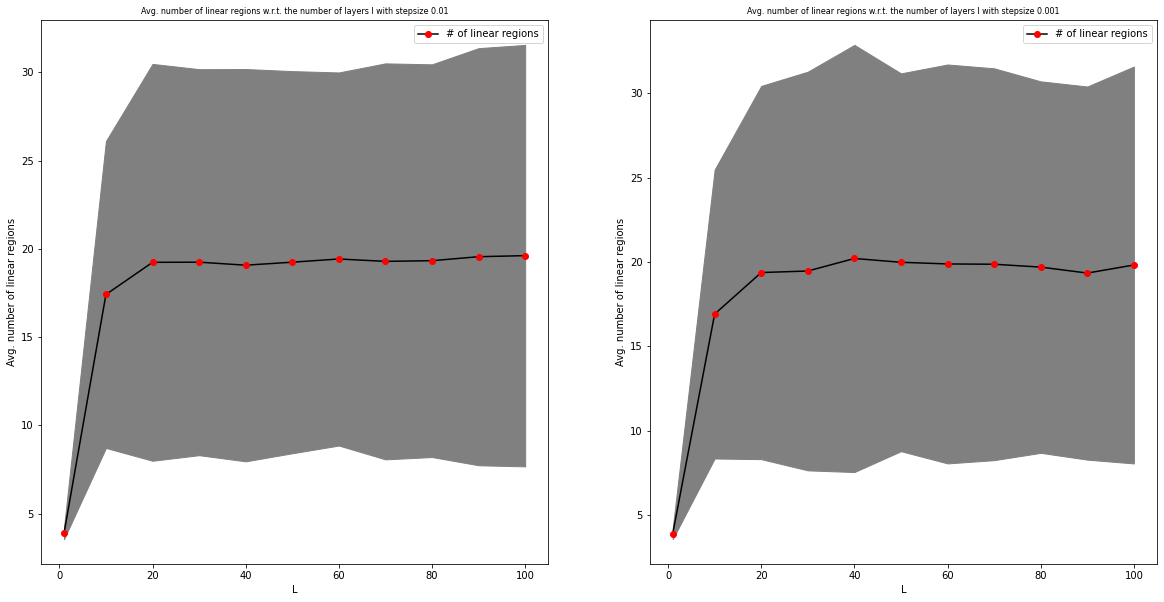

In [166]:
# plotting
fig = plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.plot(ls,nbs_4000_np,'k-',marker = 'o',mfc = 'r', mec = 'r', label = '# of linear regions')
plt.fill_between(ls, upp_4000, low_4000, color='gray')
plt.legend()

 

#plt.loglog()
plt.xlabel("L")
plt.ylabel("Avg. number of linear regions")
plt.title("Avg. number of linear regions w.r.t. the number of layers l with stepsize 0.01",fontsize=8)

plt.subplot(1, 2, 2)
plt.plot(ls,nbs_40000_np,'k-',marker = 'o',mfc = 'r', mec = 'r', label = '# of linear regions')
plt.fill_between(ls, upp_40000, low_40000, color='gray')
plt.legend()

 

#plt.loglog()
plt.xlabel("L")
plt.ylabel("Avg. number of linear regions")
plt.title("Avg. number of linear regions w.r.t. the number of layers l with stepsize 0.001",fontsize=8)

plt.savefig('figures/nb_linear_regions_stepsize.jpg')
plt.show()



### compare the average number of linear regions depening on the stepsize for a given number of layers of the 1st architecture

##### for L = 1, 10, 50, 100

In [158]:
# cosntruct the x_axis with the values of stepsize
stepsizes = np.array([0.5, 0.4, 0.2, 0.1, 0.05, 0.04, 0.02, 0.01,0.001])
# for L = 1
nbs_L1 = np.array([nbs_80[0],nbs_100[0],nbs_200[0],nbs_400[0],
                   nbs_800[0],nbs_1000[0],nbs_2000[0],nbs_4000[0],nbs_40000[0]])
stds_L1 = np.array([stds_80[0], stds_100[0],stds_200[0],stds_400[0],
                   stds_800[0],stds_1000[0],stds_2000[0],stds_4000[0],stds_40000[0]])
#for L=10
nbs_L10 = np.array([nbs_80[1],nbs_100[1],nbs_200[1],nbs_400[1],
                   nbs_800[1],nbs_1000[1],nbs_2000[1],nbs_4000[1],nbs_40000[1]])
stds_L10 = np.array([stds_80[1], stds_100[1],stds_200[1],stds_400[1],
                   stds_800[1],stds_1000[1],stds_2000[1],stds_4000[1],stds_40000[1]])
# for L = 50
nbs_L50 = np.array([nbs_80[5],nbs_100[5],nbs_200[5],nbs_400[5],
                   nbs_800[5],nbs_1000[5],nbs_2000[5],nbs_4000[5],nbs_40000[5]])
stds_L50 = np.array([stds_80[5], stds_100[5],stds_200[5],stds_400[5],
                   stds_800[5],stds_1000[5],stds_2000[5],stds_4000[5],stds_40000[5]])
# for L = 100

nbs_L100 = np.array([nbs_80[10],nbs_100[10],nbs_200[10],nbs_400[10],
                   nbs_800[10],nbs_1000[10],nbs_2000[10],nbs_4000[10],nbs_40000[10]])
stds_L100 = np.array([stds_80[10], stds_100[10],stds_200[10],stds_400[10],
                   stds_800[10],stds_1000[10],stds_2000[10],stds_4000[10],stds_40000[10]])

In [169]:
nbs_L1_upp = nbs_L1 + stds_L1
nbs_L1_low = nbs_L1 - stds_L1

nbs_L10_upp = nbs_L10 + stds_L10
nbs_L10_low = nbs_L10 - stds_L10

nbs_L50_upp = nbs_L50 + stds_L50
nbs_L50_low = nbs_L50 - stds_L50

nbs_L100_upp = nbs_L100 + stds_L100
nbs_L100_low = nbs_L100 - stds_L100

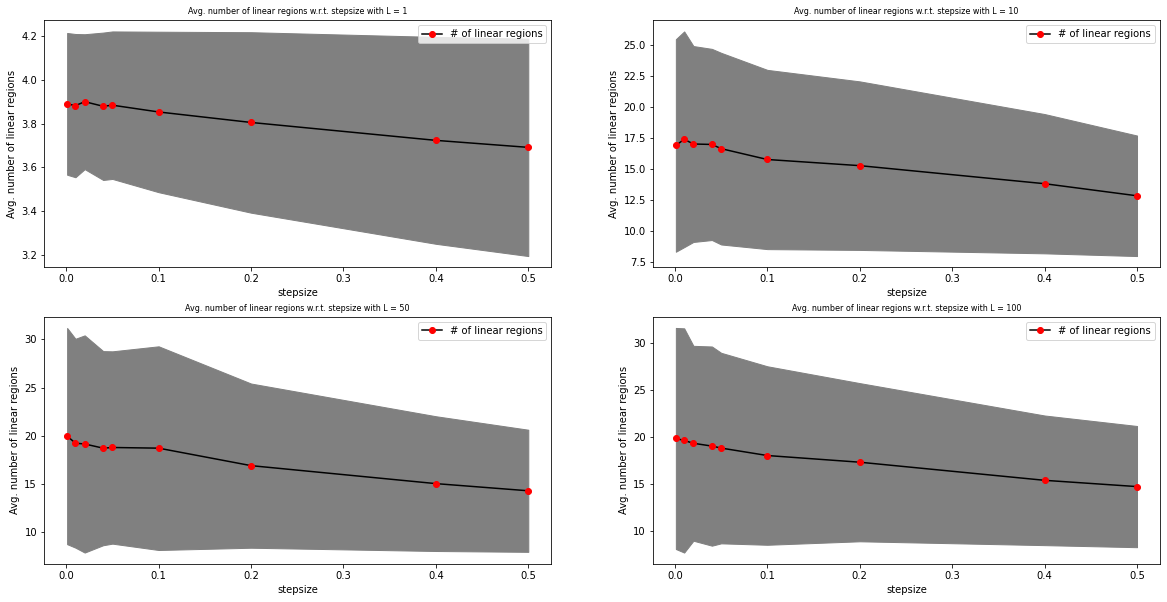

In [171]:
# plotting
# 1st plot
fig = plt.figure(figsize=(20,10))
plt.subplot(2, 2, 1)
plt.plot(stepsizes,nbs_L1,'k-',marker = 'o',mfc = 'r', mec = 'r', label = '# of linear regions')
plt.fill_between(stepsizes, nbs_L1_upp, nbs_L1_low, color='gray')
plt.legend()

plt.xlabel("stepsize")
plt.ylabel("Avg. number of linear regions")
plt.title("Avg. number of linear regions w.r.t. stepsize with L = 1",fontsize=8)
# 2nd plot
plt.subplot(2, 2, 2)
plt.plot(stepsizes,nbs_L10,'k-',marker = 'o',mfc = 'r', mec = 'r', label = '# of linear regions')
plt.fill_between(stepsizes, nbs_L10_upp, nbs_L10_low, color='gray')
plt.legend()

plt.xlabel("stepsize")
plt.ylabel("Avg. number of linear regions")
plt.title("Avg. number of linear regions w.r.t. stepsize with L = 10",fontsize=8)
# 3rd plot
plt.subplot(2, 2, 3)
plt.plot(stepsizes,nbs_L50,'k-',marker = 'o',mfc = 'r', mec = 'r', label = '# of linear regions')
plt.fill_between(stepsizes, nbs_L50_upp, nbs_L50_low, color='gray')
plt.legend()

plt.xlabel("stepsize")
plt.ylabel("Avg. number of linear regions")
plt.title("Avg. number of linear regions w.r.t. stepsize with L = 50",fontsize=8)
# 4th plot
plt.subplot(2, 2, 4)
plt.plot(stepsizes,nbs_L100,'k-',marker = 'o',mfc = 'r', mec = 'r', label = '# of linear regions')
plt.fill_between(stepsizes, nbs_L100_upp, nbs_L100_low, color='gray')
plt.legend()

plt.xlabel("stepsize")
plt.ylabel("Avg. number of linear regions")
plt.title("Avg. number of linear regions w.r.t. stepsize with L = 100",fontsize=8)

plt.savefig('figures/variation_stepsize.jpg')
plt.show()

###  2)check if the window size is not big enough

In [172]:
def nb_region_arch1(ls, n_iter, window_size, nb, save_name1, save_name2):
    avg_nbs = []
    stds = []
    for l in ls:
        stats = torch.empty(n_iter, 1)
        for i in range(n_iter):
            d = torch.linspace(-1*window_size, window_size, nb)
            d = d.reshape(-1, 1)
            d.requires_grad_(True)
            output = arch_1(d, 3, l)
            output.backward(torch.ones_like(output))
            grad = d.grad.numpy().reshape(-1)
            
            stats[i,0] = len(set(grad))
        avg_nb = stats.mean(axis = 0)[0].item()
        std = stats.std(axis = 0)[0].item()
        avg_nbs.append(avg_nb)
        stds.append(std)
        print(f'{l}, finished.')
    # save the result
    avg_nbs_tosave = np.array(avg_nbs)
    stds_tosave = np.array(stds)
    np.save(save_name1, avg_nbs_tosave)
    np.save(save_name2, stds_tosave)
    return avg_nbs, stds

In [173]:
# def. of the layers number
ls = np.arange(0,101,10)
ls[0] = 1
ls

array([  1,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100])

In [174]:
# stick with the stepsize = 0.02
nbss_80, stdss_80 = nb_region_arch1(ls, 1000, 10, 1001, 'data/arch1_nbs_w10.npy', 'data/arch1_stds_w10.npy')

1, finished.
10, finished.
20, finished.
30, finished.
40, finished.
50, finished.
60, finished.
70, finished.
80, finished.
90, finished.
100, finished.


In [176]:
# small correction for the name of variables
nbs_w10 = nbss_80
stds_w10 = stdss_80

In [177]:
nbs_w15, stds_w15 = nb_region_arch1(ls, 1000, 15, 1501, 'data/arch1_nbs_w15.npy', 'data/arch1_stds_w15.npy')

1, finished.
10, finished.
20, finished.
30, finished.
40, finished.
50, finished.
60, finished.
70, finished.
80, finished.
90, finished.
100, finished.


In [178]:
nbs_w20, stds_w20 = nb_region_arch1(ls, 1000, 20, 2001, 'data/arch1_nbs_w20.npy', 'data/arch1_stds_w20.npy')

1, finished.
10, finished.
20, finished.
30, finished.
40, finished.
50, finished.
60, finished.
70, finished.
80, finished.
90, finished.
100, finished.


In [179]:
nbs_w25, stds_w25 = nb_region_arch1(ls, 1000, 25, 2501, 'data/arch1_nbs_w25.npy', 'data/arch1_stds_w25.npy')

1, finished.
10, finished.
20, finished.
30, finished.
40, finished.
50, finished.
60, finished.
70, finished.
80, finished.
90, finished.
100, finished.


In [180]:
nbs_w30, stds_w30 = nb_region_arch1(ls, 1000, 30, 3001, 'data/arch1_nbs_w30.npy', 'data/arch1_stds_w30.npy')

1, finished.
10, finished.
20, finished.
30, finished.
40, finished.
50, finished.
60, finished.
70, finished.
80, finished.
90, finished.
100, finished.


In [181]:
nbs_w35, stds_w35 = nb_region_arch1(ls, 1000, 35, 3501, 'data/arch1_nbs_w35.npy', 'data/arch1_stds_w35.npy')

1, finished.
10, finished.
20, finished.
30, finished.
40, finished.
50, finished.
60, finished.
70, finished.
80, finished.
90, finished.
100, finished.


In [182]:
nbs_w40, stds_w40 = nb_region_arch1(ls, 1000, 40, 4001, 'data/arch1_nbs_w40.npy', 'data/arch1_stds_w40.npy')

1, finished.
10, finished.
20, finished.
30, finished.
40, finished.
50, finished.
60, finished.
70, finished.
80, finished.
90, finished.
100, finished.


In [183]:
nbs_w40_np = np.array(nbs_w40)
stds_w40_np = np.array(stds_w40)
upp_w40 = nbs_w40_np + stds_w40_np
low_w40 = nbs_w40_np - stds_w40_np

In [184]:
nbs_w20_np = np.array(nbs_w20)
stds_w20_np = np.array(stds_w20)
upp_w20 = nbs_w20_np + stds_w20_np
low_w20 = nbs_w20_np - stds_w20_np

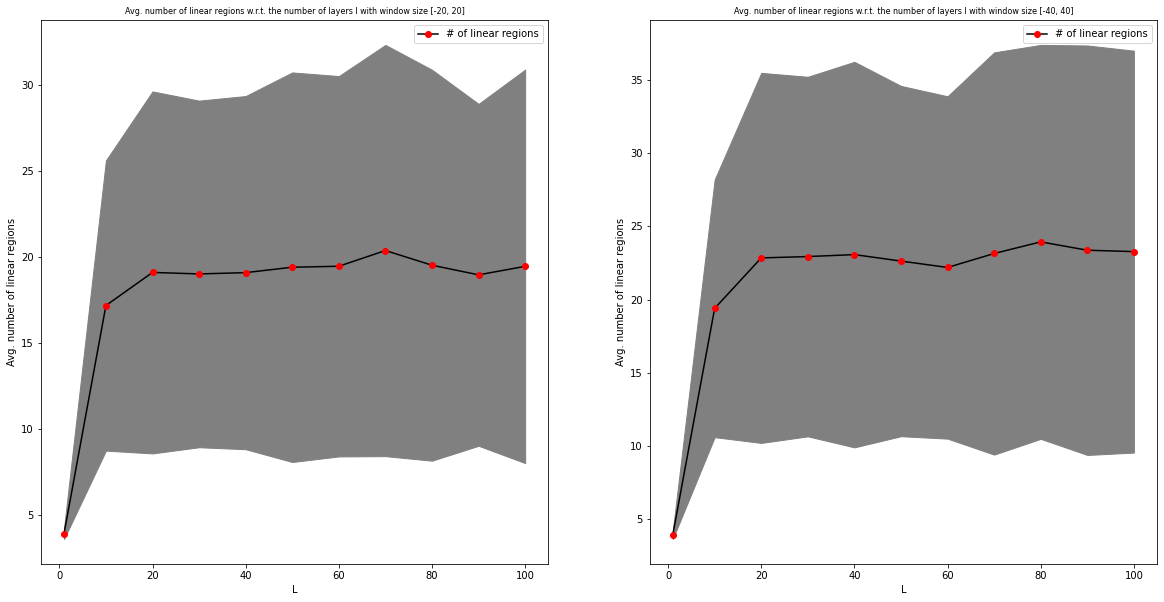

In [185]:
# plotting
fig = plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.plot(ls,nbs_w20_np,'k-',marker = 'o',mfc = 'r', mec = 'r', label = '# of linear regions')
plt.fill_between(ls, upp_w20, low_w20, color='gray')
plt.legend()

 

#plt.loglog()
plt.xlabel("L")
plt.ylabel("Avg. number of linear regions")
plt.title("Avg. number of linear regions w.r.t. the number of layers l with window size [-20, 20]",fontsize=8)

plt.subplot(1, 2, 2)
plt.plot(ls,nbs_w40_np,'k-',marker = 'o',mfc = 'r', mec = 'r', label = '# of linear regions')
plt.fill_between(ls, upp_w40, low_w40, color='gray')
plt.legend()

 

#plt.loglog()
plt.xlabel("L")
plt.ylabel("Avg. number of linear regions")
plt.title("Avg. number of linear regions w.r.t. the number of layers l with window size [-40, 40]",fontsize=8)

plt.savefig('figures/nb_linear_regions_windowsize.jpg')
plt.show()



In [189]:
# cosntruct the x_axis with the values of window sizes
wsizes = np.array([20, 30, 40, 50, 60, 70, 80])
# for L = 1
nbs_L1 = np.array([nbs_w10[0],nbs_w15[0],nbs_w20[0],nbs_w25[0],nbs_w30[0], nbs_w35[0], nbs_w40[0]])
                  
stds_L1 = np.array([stds_w10[0],stds_w15[0],stds_w20[0],stds_w25[0],stds_w30[0], stds_w35[0], stds_w40[0]])
#for L=10
nbs_L10 = np.array([nbs_w10[1],nbs_w15[1],nbs_w20[1],nbs_w25[1],nbs_w30[1], nbs_w35[1], nbs_w40[1]])

stds_L10 = np.array([stds_w10[1],stds_w15[1],stds_w20[1],stds_w25[1],stds_w30[1], stds_w35[1], stds_w40[1]])

# for L = 50
nbs_L50 = np.array([nbs_w10[5],nbs_w15[5],nbs_w20[5],nbs_w25[5],nbs_w30[5], nbs_w35[5], nbs_w40[5]])

stds_L50 =  np.array([stds_w10[5],stds_w15[5],stds_w20[5],stds_w25[5],stds_w30[5], stds_w35[5], stds_w40[5]])

# for L = 100

nbs_L100 = np.array([nbs_w10[10],nbs_w15[10],nbs_w20[10],nbs_w25[10],nbs_w30[10], nbs_w35[10], nbs_w40[10]])

stds_L100 =  np.array([stds_w10[10],stds_w15[10],stds_w20[10],stds_w25[10],stds_w30[10], stds_w35[10], stds_w40[10]])

In [190]:
nbs_L1_upp = nbs_L1 + stds_L1
nbs_L1_low = nbs_L1 - stds_L1

nbs_L10_upp = nbs_L10 + stds_L10
nbs_L10_low = nbs_L10 - stds_L10

nbs_L50_upp = nbs_L50 + stds_L50
nbs_L50_low = nbs_L50 - stds_L50

nbs_L100_upp = nbs_L100 + stds_L100
nbs_L100_low = nbs_L100 - stds_L100

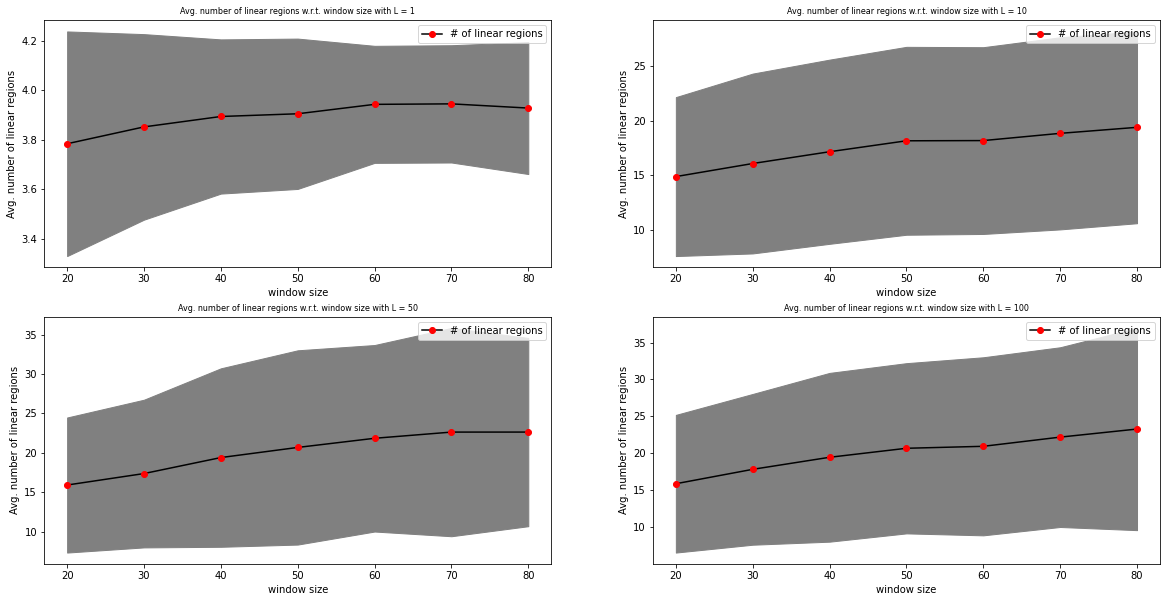

In [191]:
# plotting
# 1st plot
fig = plt.figure(figsize=(20,10))
plt.subplot(2, 2, 1)
plt.plot(wsizes,nbs_L1,'k-',marker = 'o',mfc = 'r', mec = 'r', label = '# of linear regions')
plt.fill_between(wsizes, nbs_L1_upp, nbs_L1_low, color='gray')
plt.legend()

plt.xlabel("window size")
plt.ylabel("Avg. number of linear regions")
plt.title("Avg. number of linear regions w.r.t. window size with L = 1",fontsize=8)
# 2nd plot
plt.subplot(2, 2, 2)
plt.plot(wsizes,nbs_L10,'k-',marker = 'o',mfc = 'r', mec = 'r', label = '# of linear regions')
plt.fill_between(wsizes, nbs_L10_upp, nbs_L10_low, color='gray')
plt.legend()

plt.xlabel("window size")
plt.ylabel("Avg. number of linear regions")
plt.title("Avg. number of linear regions w.r.t. window size with L = 10",fontsize=8)
# 3rd plot
plt.subplot(2, 2, 3)
plt.plot(wsizes,nbs_L50,'k-',marker = 'o',mfc = 'r', mec = 'r', label = '# of linear regions')
plt.fill_between(wsizes, nbs_L50_upp, nbs_L50_low, color='gray')
plt.legend()

plt.xlabel("window size")
plt.ylabel("Avg. number of linear regions")
plt.title("Avg. number of linear regions w.r.t. window size with L = 50",fontsize=8)
# 4th plot
plt.subplot(2, 2, 4)
plt.plot(wsizes,nbs_L100,'k-',marker = 'o',mfc = 'r', mec = 'r', label = '# of linear regions')
plt.fill_between(wsizes, nbs_L100_upp, nbs_L100_low, color='gray')
plt.legend()

plt.xlabel("window size")
plt.ylabel("Avg. number of linear regions")
plt.title("Avg. number of linear regions w.r.t. window size with L = 100",fontsize=8)

plt.savefig('figures/variation_windowsize.jpg')
plt.show()

# the 2nd architecture

In [192]:
def arch_2(d, k, l):
    ghh1 = GHH(d,2,k)
    res = ghh1(d)
    
    for i in range(l-1):
        ghh = GHH(res,1,k)
        res = res.clone()
        res = ghh(res)
        
    output = res.clone()
    return output

In [197]:
def nb_region_arch2(x_range, y_range, step, ls, n_iter, save_name1, save_name2):
    avg_nbs = []
    stds = []
    for l in ls:
        stats = torch.empty(n_iter, 1)
        for i in range(n_iter):
            d, ll = generate_grid(x_range, y_range, step)
            d.requires_grad_(True)
            output = arch_2(d, 3, l)
            grad_x, grad_y = compute_grad(output, d, ll)
            reg = get_region_fast(grad_x, grad_y)
            
            stats[i,0] = len(set(reg.flatten()))
        avg_nb = stats.mean(axis = 0)[0].item()
        std = stats.std(axis = 0)[0].item()
        avg_nbs.append(avg_nb)
        stds.append(std)
        print(f'{l}, finished.')
    
    # save the result
    avg_nbs_tosave = np.array(avg_nbs)
    stds_tosave = np.array(stds)
    np.save(save_name1, avg_nbs_tosave)
    np.save(save_name2, stds_tosave)
    return avg_nbs, stds

### 1) stepsize

In [198]:
x_range = [-10, 10]
y_range = [-10, 10]
ls = np.arange(0,21,2)
ls[0] = 1
ls

array([ 1,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20])

In [202]:
nbs_05, stds_05 = nb_region_arch2(x_range, y_range, 0.5, ls, 1000, 'arch2/nbs_05.npy', 'arch2/stds_05.npy')

1, finished.
2, finished.
4, finished.
6, finished.
8, finished.
10, finished.
12, finished.
14, finished.
16, finished.
18, finished.
20, finished.


In [203]:
nbs_02, stds_02 = nb_region_arch2(x_range, y_range, 0.2, ls, 1000, 'arch2/nbs_02.npy', 'arch2/stds_02.npy')

1, finished.
2, finished.
4, finished.
6, finished.
8, finished.
10, finished.
12, finished.
14, finished.
16, finished.
18, finished.
20, finished.


In [199]:
nbs_01, stds_01 = nb_region_arch2(x_range, y_range, 0.1, ls, 1000, 'arch2/nbs_01.npy', 'arch2/stds_01.npy')

1, finished.
2, finished.
4, finished.
6, finished.
8, finished.
10, finished.
12, finished.
14, finished.
16, finished.
18, finished.
20, finished.


In [204]:
nbs_005, stds_005 = nb_region_arch2(x_range, y_range, 0.05, ls, 1000, 'arch2/nbs_005.npy', 'arch2/stds_005.npy')

1, finished.
2, finished.
4, finished.
6, finished.
8, finished.
10, finished.
12, finished.
14, finished.
16, finished.
18, finished.
20, finished.


In [ ]:
nbs_002, stds_002 = nb_region_arch2(x_range, y_range, 0.02, ls, 1000, 'arch2/nbs_002.npy', 'arch2/stds_002.npy')

In [ ]:
nbs_001, stds_001 = nb_region_arch2(x_range, y_range, 0.01, ls, 1000, 'arch2/nbs_001.npy', 'arch2/stds_001.npy')

In [206]:
nbs_005_np = np.array(nbs_005)
stds_005_np = np.array(stds_005)
upp_005 = nbs_005_np + stds_005_np
low_005 = nbs_005_np - stds_005_np

In [207]:
nbs_01_np = np.array(nbs_01)
stds_01_np = np.array(stds_01)
upp_01 = nbs_01_np + stds_01_np
low_01 = nbs_01_np - stds_01_np

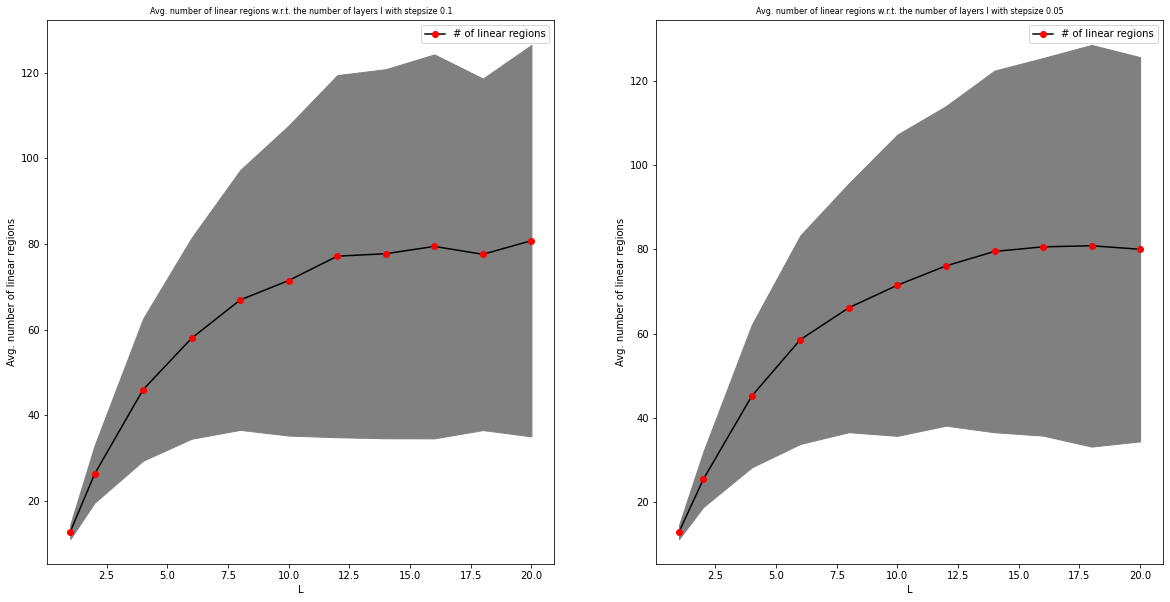

In [208]:
# plotting
fig = plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.plot(ls,nbs_01_np,'k-',marker = 'o',mfc = 'r', mec = 'r', label = '# of linear regions')
plt.fill_between(ls, upp_01, low_01, color='gray')
plt.legend()

 

#plt.loglog()
plt.xlabel("L")
plt.ylabel("Avg. number of linear regions")
plt.title("Avg. number of linear regions w.r.t. the number of layers l with stepsize 0.1",fontsize=8)

plt.subplot(1, 2, 2)
plt.plot(ls,nbs_005_np,'k-',marker = 'o',mfc = 'r', mec = 'r', label = '# of linear regions')
plt.fill_between(ls, upp_005, low_005, color='gray')
plt.legend()

 

#plt.loglog()
plt.xlabel("L")
plt.ylabel("Avg. number of linear regions")
plt.title("Avg. number of linear regions w.r.t. the number of layers l with stepsize 0.05",fontsize=8)

plt.savefig('figures/nb_linear_regions_stepsize_arch2.jpg')
plt.show()


In [214]:
# cosntruct the x_axis with the values of stepsize
stepsizes = np.array([0.5, 0.2, 0.1, 0.05])
# for L = 1
nbs_L1 = np.array([nbs_05[0],nbs_02[0],nbs_01[0],nbs_005[0]])

stds_L1 = np.array([stds_05[0], stds_02[0],stds_01[0],stds_005[0]])
#for L=2
nbs_L10 = np.array([nbs_05[1],nbs_02[1],nbs_01[1],nbs_005[1]])

stds_L10 = np.array([stds_05[1], stds_02[1],stds_01[1],stds_005[1]])
# for L = 10
nbs_L50 = np.array([nbs_05[5],nbs_02[5],nbs_01[5],nbs_005[5]])

stds_L50 = np.array([stds_05[5], stds_02[5],stds_01[5],stds_005[5]])
# for L = 20

nbs_L100 = np.array([nbs_05[10],nbs_02[10],nbs_01[10],nbs_005[10]])

stds_L100 = np.array([stds_05[10], stds_02[10],stds_01[10],stds_005[10]])

In [215]:
nbs_L1_upp = nbs_L1 + stds_L1
nbs_L1_low = nbs_L1 - stds_L1

nbs_L10_upp = nbs_L10 + stds_L10
nbs_L10_low = nbs_L10 - stds_L10

nbs_L50_upp = nbs_L50 + stds_L50
nbs_L50_low = nbs_L50 - stds_L50

nbs_L100_upp = nbs_L100 + stds_L100
nbs_L100_low = nbs_L100 - stds_L100

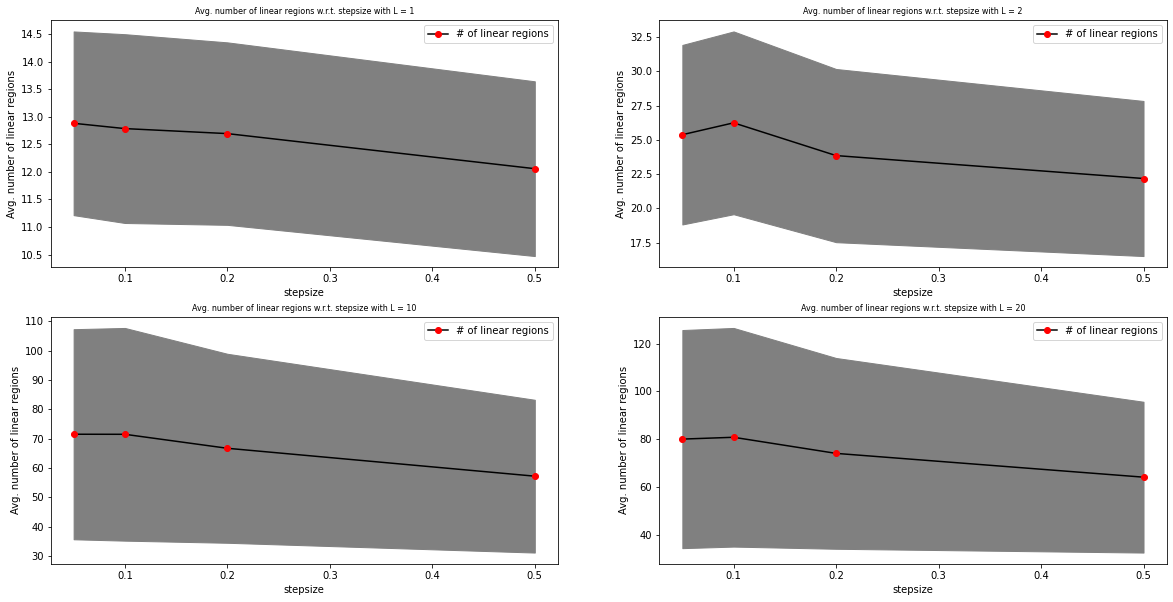

In [216]:
# plotting
# 1st plot
fig = plt.figure(figsize=(20,10))
plt.subplot(2, 2, 1)
plt.plot(stepsizes,nbs_L1,'k-',marker = 'o',mfc = 'r', mec = 'r', label = '# of linear regions')
plt.fill_between(stepsizes, nbs_L1_upp, nbs_L1_low, color='gray')
plt.legend()

plt.xlabel("stepsize")
plt.ylabel("Avg. number of linear regions")
plt.title("Avg. number of linear regions w.r.t. stepsize with L = 1",fontsize=8)
# 2nd plot
plt.subplot(2, 2, 2)
plt.plot(stepsizes,nbs_L10,'k-',marker = 'o',mfc = 'r', mec = 'r', label = '# of linear regions')
plt.fill_between(stepsizes, nbs_L10_upp, nbs_L10_low, color='gray')
plt.legend()

plt.xlabel("stepsize")
plt.ylabel("Avg. number of linear regions")
plt.title("Avg. number of linear regions w.r.t. stepsize with L = 2",fontsize=8)
# 3rd plot
plt.subplot(2, 2, 3)
plt.plot(stepsizes,nbs_L50,'k-',marker = 'o',mfc = 'r', mec = 'r', label = '# of linear regions')
plt.fill_between(stepsizes, nbs_L50_upp, nbs_L50_low, color='gray')
plt.legend()

plt.xlabel("stepsize")
plt.ylabel("Avg. number of linear regions")
plt.title("Avg. number of linear regions w.r.t. stepsize with L = 10",fontsize=8)
# 4th plot
plt.subplot(2, 2, 4)
plt.plot(stepsizes,nbs_L100,'k-',marker = 'o',mfc = 'r', mec = 'r', label = '# of linear regions')
plt.fill_between(stepsizes, nbs_L100_upp, nbs_L100_low, color='gray')
plt.legend()

plt.xlabel("stepsize")
plt.ylabel("Avg. number of linear regions")
plt.title("Avg. number of linear regions w.r.t. stepsize with L = 20",fontsize=8)

plt.savefig('figures/variation_stepsize_arch2.jpg')
plt.show()

### 2)window size

In [219]:
# for a window size [-10, 10], reuse the result earlier
nbs_w10 = np.load('arch2/nbs_005.npy')
stds_w10 = np.load('arch2/stds_005.npy')

In [221]:
x_range = [-15, 15]
y_range = [-15, 15]
nbs_w15, stds_w15 = nb_region_arch2(x_range, y_range, 0.05, ls, 1000, 'arch2/nbs_w15.npy', 'arch2/stds_w15.npy')

1, finished.
2, finished.
4, finished.
6, finished.
8, finished.
10, finished.
12, finished.
14, finished.
16, finished.
18, finished.
20, finished.


In [222]:
x_range = [-20, 20]
y_range = [-20, 20]
nbs_w20, stds_w20 = nb_region_arch2(x_range, y_range, 0.05, ls, 1000, 'arch2/nbs_w20.npy', 'arch2/stds_w20.npy')

1, finished.
2, finished.
4, finished.
6, finished.
8, finished.
10, finished.


KeyboardInterrupt: 

In [ ]:
x_range = [-30, 30]
y_range = [-30, 30]
nbs_w30, stds_w30 = nb_region_arch2(x_range, y_range, 0.05, ls, 1000, 'arch2/nbs_w30.npy', 'arch2/stds_w30.npy')

In [224]:
nbs_w10_np = np.array(nbs_w10)
stds_w10_np = np.array(stds_w10)
upp_w10 = nbs_w10_np + stds_w10_np
low_w10 = nbs_w10_np - stds_w10_np

In [225]:
nbs_w15_np = np.array(nbs_w15)
stds_w15_np = np.array(stds_w15)
upp_w15 = nbs_w15_np + stds_w15_np
low_w15 = nbs_w15_np - stds_w15_np

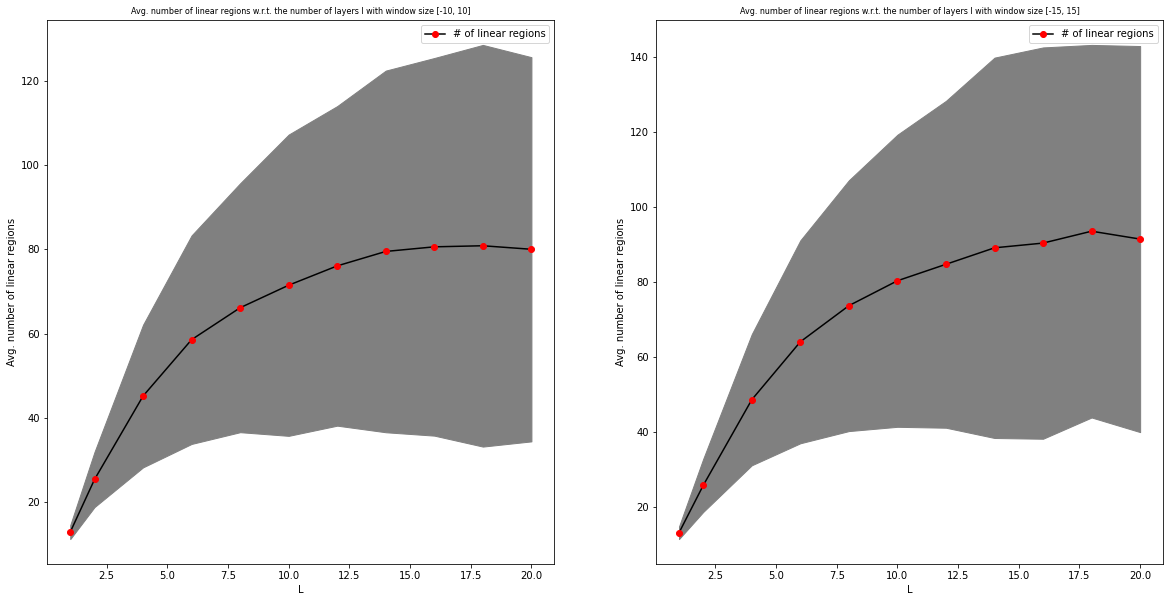

In [226]:
# plotting
fig = plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.plot(ls,nbs_w10_np,'k-',marker = 'o',mfc = 'r', mec = 'r', label = '# of linear regions')
plt.fill_between(ls, upp_w10, low_w10, color='gray')
plt.legend()

 

#plt.loglog()
plt.xlabel("L")
plt.ylabel("Avg. number of linear regions")
plt.title("Avg. number of linear regions w.r.t. the number of layers l with window size [-10, 10]",fontsize=8)

plt.subplot(1, 2, 2)
plt.plot(ls,nbs_w15_np,'k-',marker = 'o',mfc = 'r', mec = 'r', label = '# of linear regions')
plt.fill_between(ls, upp_w15, low_w15, color='gray')
plt.legend()

 

#plt.loglog()
plt.xlabel("L")
plt.ylabel("Avg. number of linear regions")
plt.title("Avg. number of linear regions w.r.t. the number of layers l with window size [-15, 15]",fontsize=8)

plt.savefig('figures/nb_linear_regions_windowsize_arch2.jpg')
plt.show()